## Into
In this notebook I will be using keras to build and run a classification of movie reviews using a dataset loaded from keras. I will be thinking of the beginning of this file as more of a tutorial on how to build these models. As someone new to deep learing and keras, I was having to do this informally for my own sake but I figured it might be even more beneficial to myself to make this process part of my biweekly report and do it more formally. My goal in this file is to really break the code down almost line by line and explain what is going on as if the reader is a total beginner. After I do this and understand keras a bit more, I will create a bunch of other models to see how they do.

I found many resources online would come at this topic from the assumption that the reader already has a good understanding of the underlying techniques and was just looking for the code to perform these techniques. However, I am new to NLP and deep learning so while many of these "tutorials" were helpful for learning how to make the model, they failed to help me understand what was going on line by line behind the scenes. 

In [4]:
import numpy as np
from keras.utils import to_categorical
from keras import models
from keras import layers
from keras.datasets import imdb
import matplotlib.pyplot as plt

The dataset I will import from keras has 50,000 movie reviews from IMDB that have been labelled as a 1 (positive) or 0 (negative). Each review is encoded as a sequence of indices of words. The words of the reviews are indexed by their overall frequency within the dataset. For example, the integer “2” encodes the second most frequent word in the data. Most of the code for my first model will be coming from the link https://builtin.com/data-science/how-build-neural-network-keras. 

In [2]:
##Load the data
#Words are ranked by how often they occur (in the training set) and only the num_words most frequent words are kept
(training_data, training_targets), (testing_data, testing_targets) = imdb.load_data(num_words=10000)
#Merge the data and targets back together to split later in a non 50/50 split
data = np.concatenate((training_data, testing_data), axis=0)
targets = np.concatenate((training_targets, testing_targets), axis=0)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

To help understand what type of data we are dealing with, perform a little bit of data exploration

In [3]:
print(data[2])

[1, 14, 47, 8, 30, 31, 7, 4, 249, 108, 7, 4, 5974, 54, 61, 369, 13, 71, 149, 14, 22, 112, 4, 2401, 311, 12, 16, 3711, 33, 75, 43, 1829, 296, 4, 86, 320, 35, 534, 19, 263, 4821, 1301, 4, 1873, 33, 89, 78, 12, 66, 16, 4, 360, 7, 4, 58, 316, 334, 11, 4, 1716, 43, 645, 662, 8, 257, 85, 1200, 42, 1228, 2578, 83, 68, 3912, 15, 36, 165, 1539, 278, 36, 69, 2, 780, 8, 106, 14, 6905, 1338, 18, 6, 22, 12, 215, 28, 610, 40, 6, 87, 326, 23, 2300, 21, 23, 22, 12, 272, 40, 57, 31, 11, 4, 22, 47, 6, 2307, 51, 9, 170, 23, 595, 116, 595, 1352, 13, 191, 79, 638, 89, 2, 14, 9, 8, 106, 607, 624, 35, 534, 6, 227, 7, 129, 113]


We see that data is an array of arrays and at each index is a row vector representing a review with each index inside this vector representing how common the words are.

In [4]:
print(targets[2])

0


From the above cell, we see that the review indexed by 2 was a negative review since the target is 0.

In [5]:
print("Targets:", np.unique(targets))
print("Number of unique words:", len(np.unique(np.hstack(data))))
length = [len(i) for i in data]
print("Average number of words:", np.mean(length))


Targets: [0 1]
Number of unique words: 9998
Average number of words: 234.75892


Again we see the possible classifications of 0 or 1 with the number of unique words and the average length of a review.

We will vectorize every review and fill it with zeros so it contains exactly 10,000 numbers. That means we fill every review that is shorter than 10,000 with zeros. We need to do this because the biggest review is nearly that long and every input for our neural network needs to have the same size. 

In [6]:
def vectorize(sequences):
    results = np.zeros((len(sequences), 10000))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1
    return results

We will then split our data into an 80/20 training/testing split

In [7]:
data = vectorize(data)
targets = np.array(targets).astype("uint8")
test_x = data[:10000]
test_y = targets[:10000]
train_x = data[10000:]
train_y = targets[10000:]

Now time for the fun stuff. I will begin by making a sequential model in keras. Keras provides functionality of either the sequential class or the model class. The sequential class groups a linear stack of layers into a tf.keras.Model while the model class groups layers into an object with training and inference features. The sequential model is considered to be easier because it allows users to create models layer by layer in a "sequential" manner.

In [8]:
#Initialize the model
model = models.Sequential()

Now lets add some layers to the model. We will add the input layer with an activation function of relu. Notice how this layer is using layers.Dense. The documentation of keras from the link https://keras.io/api/layers/core_layers/dense/ states "Dense implements the operation: output = activation(dot(input, kernel) + bias) where activation is the element-wise activation function passed as the activation argument, kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer (only applicable if use_bias is True)."

I believe use_bias is passed as true unless stated otherwise and with our activation function of relu, we have all the information for the operation: output = activation(dot(input, kernel) + bias). The parameters of 50 and input_shape=(10000, ) mean that the input shape is 10000 (size of our reviews) and then the output will be a size of 50.

In [9]:
model.add(layers.Dense(50, activation = "relu", input_shape=(10000, )))

Now we will add some hidden layers. We will add two dropout layers and two dense layers. The dropout layers help ensure that the model is not overfitting by ignoring or "dropping" some outputs of the layer. The first parameter is the rate at which the layer randomly sets the input units to 0. Keras documentation states that noise_shape is a "1D integer tensor representing the shape of the binary dropout mask that will be multiplied with the input". The seed parameter is just there to be a random seed if you want a noise_shape. 

In [10]:
model.add(layers.Dropout(0.3, noise_shape=None, seed=None))
model.add(layers.Dense(50, activation = "relu"))
model.add(layers.Dropout(0.2, noise_shape=None, seed=None))
model.add(layers.Dense(50, activation = "relu"))

We then need the output layer to map these values to a single value. Once again, the first number is the size of the output and the activation function is a sigmoid. 

In [11]:
model.add(layers.Dense(1, activation = "sigmoid"))

Now we have a model built using the summary() function we can see everything that we have done clearly

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                500050    
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 505,201
Trainable params: 505,201
Non-trainable params: 0
__________________________________________________

Now we need to compile the model, meaning we need to prepare it for training. The "adam" optimizer is an algorithm to change the weights/biases while training. The loss function is binary_crossentropy because the output of this model needs to be a 0 or 1. The evaluation metric is accuracy but you could also look at a variety of other metrics as seen in the link https://www.tensorflow.org/api_docs/python/tf/keras/metrics.

In [13]:
model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)

Now it is time to train the model. Using the training data, we run 2 epochs with a batch size of 500 and validation data of our test data. Batch size is simply the number of samples in each chunk that the model will look at to train. The keras documentation states that the validation_data parameter is "data on which to evaluate the loss and any model metrics at the end of each epoch. The model will not be trained on this data".

In [15]:
train_x = np.array(train_x, dtype=np.int8)
train_y = np.array(train_y, dtype=np.int8)
results1 = model.fit(
 train_x, train_y,
 epochs= 20,
 batch_size = 500,
 validation_data = (test_x, test_y)
)
print("Test-Accuracy:", np.mean(results1.history["val_accuracy"]))

Epoch 1/20
80/80 [==============================] - 4s 54ms/step - loss: 0.0178 - accuracy: 0.9933 - val_loss: 0.6907 - val_accuracy: 0.8800
Epoch 2/20
80/80 [==============================] - 4s 51ms/step - loss: 0.0157 - accuracy: 0.9945 - val_loss: 0.7152 - val_accuracy: 0.8817
Epoch 3/20
80/80 [==============================] - 4s 52ms/step - loss: 0.0148 - accuracy: 0.9945 - val_loss: 0.7651 - val_accuracy: 0.8824
Epoch 4/20
80/80 [==============================] - 9s 109ms/step - loss: 0.0154 - accuracy: 0.9949 - val_loss: 0.6865 - val_accuracy: 0.8821
Epoch 5/20
80/80 [==============================] - 4s 52ms/step - loss: 0.0127 - accuracy: 0.9956 - val_loss: 0.7276 - val_accuracy: 0.8809
Epoch 6/20
80/80 [==============================] - 4s 53ms/step - loss: 0.0131 - accuracy: 0.9956 - val_loss: 0.7817 - val_accuracy: 0.8816
Epoch 7/20
80/80 [==============================] - 4s 52ms/step - loss: 0.0127 - accuracy: 0.9956 - val_loss: 0.7285 - val_accuracy: 0.8829
Epoch 8/20
8

In [3]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel("Epochs")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.xlabel("Epochs")

    plt.title('Training and validation loss')
    plt.legend()
    
plot_history(results1)

NameError: ignored

Wow with a model as simple as this, we get a really good accuracy of nearly .9. This took a very short time to run so for this high of an accuracy this is very good. It is interesting to note that while the number of epochs increases the training accuracy, it does not actually increase the validation accuracy. We can see a similar story in the loss plot, because it shows the training loss to decline while the validation loss actually increases. 

I am just curious to see the affect the dropout rate has on the model. In both layers I will change the dropout rate to .5.

In [17]:
(training_data, training_targets), (testing_data, testing_targets) = imdb.load_data(num_words=10000)
data = np.concatenate((training_data, testing_data), axis=0)
targets = np.concatenate((training_targets, testing_targets), axis=0)
def vectorize(sequences, dimension = 10000):
 results = np.zeros((len(sequences), dimension))
 for i, sequence in enumerate(sequences):
  results[i, sequence] = 1
 return results
 
data = vectorize(data)
targets = np.array(targets).astype("float32")
test_x = data[:10000]
test_y = targets[:10000]
train_x = data[10000:]
train_y = targets[10000:]
model = models.Sequential()
# Input - Layer
model.add(layers.Dense(50, activation = "relu", input_shape=(10000, )))
# Hidden - Layers
model.add(layers.Dropout(0.5, noise_shape=None, seed=None))
model.add(layers.Dense(50, activation = "relu"))
model.add(layers.Dropout(0.5, noise_shape=None, seed=None))
model.add(layers.Dense(50, activation = "relu"))
# Output- Layer
model.add(layers.Dense(1, activation = "sigmoid"))
model.summary()
# compiling the model
model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)
results2 = model.fit(
 train_x, train_y,
 epochs= 20,
 batch_size = 500,
 validation_data = (test_x, test_y)
)
print("Test-Accuracy:", np.mean(results2.history["val_accuracy"]))

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                500050    
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 505,201
Trainable params: 505,201
Non-trainable params: 0
________________________________________________

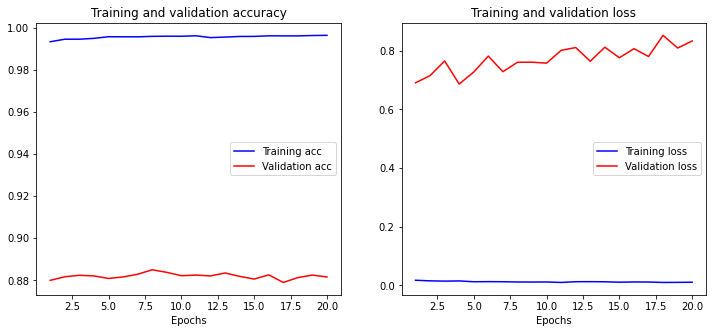

In [20]:
# First model
plot_history(results1)

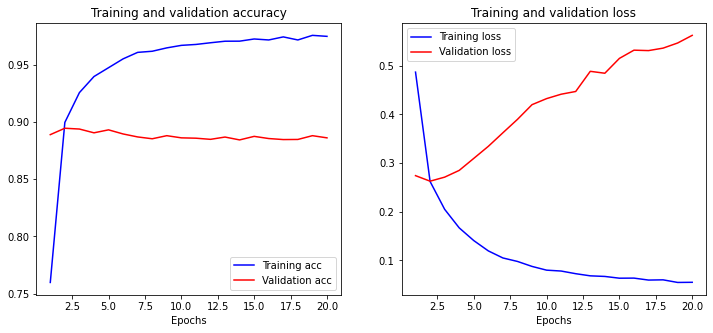

In [21]:
#second model
plot_history(results2)

As I would expect, the two models perform very similarly. It seems like increasing the dropout rate slightly increased. It is pretty strange though to see how different the plots look for the first model to the second model considering the only difference is the dropout rate.

Now I will build and train a model using the Model class. I will make a bidirectional LSTM to do sentiment classification of the same dataset as before. 

In [1]:
import numpy as np
from tensorflow import keras
from keras.utils import to_categorical
from keras import models
from keras import layers
from keras.datasets import imdb
max_features = 10000  
maxlen = 100  

inputs = keras.Input(shape=(None,), dtype="int32")
x = layers.Embedding(max_features, 128)(inputs)
# Add 2 bidirectional LSTMs
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()

(training_data, training_targets), (testing_data, testing_targets) = imdb.load_data(num_words=10000)
data = np.concatenate((training_data, testing_data), axis=0)
targets = np.concatenate((training_targets, testing_targets), axis=0)


def vectorize(sequences, dimension = 10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1
    return results
 
data = data[:4000]
targets = targets[:4000]
data = vectorize(data)

test_x = data[:2000]
test_y = targets[:2000]
train_x = data[2000:]
train_y = targets[2000:]

train_x = keras.preprocessing.sequence.pad_sequences(train_x, maxlen = maxlen)
test_x = keras.preprocessing.sequence.pad_sequences(test_x, maxlen = maxlen)

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
results = model.fit(train_x, train_y, batch_size=32, epochs=20, validation_data=(test_x, test_y))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,477,761
Trainable params: 1,477,761
Non-trainable params: 0
_________________________________________________________________
17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

Epoch 1/20
63/63 [==============================] - 26s 320ms/step - loss: 0.6941 - accuracy: 0.4934 - val_loss: 0.6929 - val_accuracy: 0.5115
Epoch 2/20
63/63 [==============================] - 18s 286ms/step - loss: 0.6934 - accuracy: 0.5062 - val_loss: 0.6932 - val_accuracy: 0.4885
Epoch 3/20
63/63 [==============================] - 18s 286ms/step - loss: 0.6935 - accuracy: 0.4746 - val_loss: 0.6930 - val_accuracy: 0.5115
Epoch 4/20
63/63 [==============================] - 18s 285ms/step - loss: 0.6935 - accuracy: 0.4926 - val_loss: 0.6929 - val_accuracy: 0.5115
Epoch 5/20
63/63 [==============================] - 18s 285ms/step - loss: 0.6931 - accuracy: 0.5094 - val_loss: 0.6929 - val_accuracy: 0.5115
Epoch 6/20
63/63 [==============================] - 18s 287ms/step - loss: 0.6935 - accuracy: 0.4968 - val_loss: 0.6929 - val_accuracy: 0.5115
Epoch 7/20
63/63 [==============================] - 18s 287ms/step - loss: 0.6930 - accuracy: 0.5040 - val_loss: 0.6928 - val_accuracy: 0.5100

Clearly the above results are not as impressive as the sequential model. I also noticed the drastic difference in the time it took for this model to train. I had significantly reduce the size of the dataset in order for the training to not taking too long which Im sure reduced the accuracy. Even with this, I was dissapointed to see how poorly the model did when looking at the validation accuracy metric.

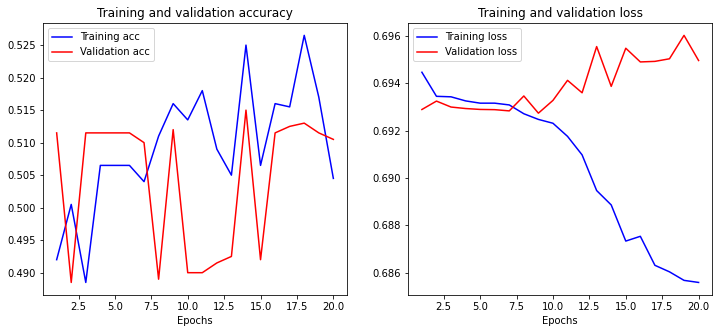

In [5]:
plot_history(results)

The accuracy plot does not seem to indicate any clear trend upwards for the validation accuracy so that is a little disappointing.

Lets see what happens if we use the Sequential class to make the bidirectional lstm

In [6]:
import numpy as np
from tensorflow import keras
from keras.utils import to_categorical
from keras import models
from keras import layers
from keras.datasets import imdb
max_features = 10000  
maxlen = 100 
(training_data, training_targets), (testing_data, testing_targets) = imdb.load_data(num_words=10000)
data = np.concatenate((training_data, testing_data), axis=0)
targets = np.concatenate((training_targets, testing_targets), axis=0)
def vectorize(sequences, dimension = 10000):
 results = np.zeros((len(sequences), dimension))
 for i, sequence in enumerate(sequences):
  results[i, sequence] = 1
 return results
 
data = data[:4000]
targets = targets[:4000]
data = vectorize(data)

test_x = data[:2000]
test_y = targets[:2000]
train_x = data[2000:]
train_y = targets[2000:]

train_x = keras.preprocessing.sequence.pad_sequences(train_x, maxlen = maxlen)
test_x = keras.preprocessing.sequence.pad_sequences(test_x, maxlen = maxlen)
model = models.Sequential()
# # Input - Layer
# model.add(layers.Dense(50, activation = "relu", input_shape=(10000, )))
# # Hidden - Layers
model.add(layers.Embedding(max_features, 128))
model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True )))
model.add(layers.Bidirectional(layers.LSTM(64)))

# Output- Layer
model.add(layers.Dense(1, activation = "sigmoid"))
model.summary()
# compiling the model
model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)
results = model.fit(
 train_x, train_y,
 epochs= 20,
 batch_size = 32,
 validation_data = (test_x, test_y)
)
print("Test-Accuracy:", np.mean(results.history["val_accuracy"]))

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,477,761
Trainable params: 1,477,761
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
63/63 [==============================] - 25s 316ms/step - loss: 0.6954 - accuracy: 0.4811 - val_loss: 0.6929 - val_accuracy: 0.5115
Epoch 2/20
63/63 [==============================] - 19s 301ms/step - loss: 0.6930 - accuracy: 0.5071 

Again, due to the incredibly large amount of time it would take for me to run this model with the full training and testing dataset, I had to significantly reduce the dataset. Again the accuracy does not seem to be very good, perhaps in part due to the much smaller dataset.

In [ ]:
plot_history(results)

In the following cell I will make a bidirectional lstm model.

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

max_features = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review

inputs = keras.Input(shape=(None,), dtype="int32")
# Embed each integer in a 128-dimensional vector
x = layers.Embedding(max_features, 128)(inputs)
# Add 2 bidirectional LSTMs
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
# Add a classifier
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()


(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(
    num_words=max_features
)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
# Use pad_sequence to standardize sequence length:
# this will truncate sequences longer than 200 words and zero-pad sequences shorter than 200 words.
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.fit(x_train, y_train, batch_size=32, epochs=2, validation_data=(x_val, y_val))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         2560000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,757,761
Trainable params: 2,757,761
Non-trainable params: 0
_________________________________________________________________


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

25000 Training sequences
25000 Validation sequences
Epoch 1/2
782/782 [==============================] - 471s 595ms/step - loss: 0.4954 - accuracy: 0.7416 - val_loss: 0.3071 - val_accuracy: 0.8706
Epoch 2/2
440/782 [===============>..............] - ETA: 2:50 - loss: 0.1923 - accuracy: 0.9325

Although the above model took a decently long time to train, the results were pretty good. A validation accuracy is so much better than some of the other models I made. I expect part of this is because I was able to use the full dataset to train.

In the following cell I will be using to global max pool model to see what happens.

In [ ]:
import numpy as np
from tensorflow import keras
from keras.utils import to_categorical
from keras import models
from keras import layers
from keras.datasets import imdb
embedding_dim = 50
(training_data, training_targets), (testing_data, testing_targets) = imdb.load_data(num_words=10000)
data = np.concatenate((training_data, testing_data), axis=0)
targets = np.concatenate((training_targets, testing_targets), axis=0)
def vectorize(sequences, dimension = 10000):
 results = np.zeros((len(sequences), dimension))
 for i, sequence in enumerate(sequences):
  results[i, sequence] = 1
 return results
 
data = vectorize(data)
targets = np.array(targets).astype("float32")
test_x = data[:10000]
test_y = targets[:10000]
train_x = data[10000:]
train_y = targets[10000:]
model = models.Sequential()
model.add(layers.Embedding(input_dim=50, 
                           output_dim=embedding_dim, 
                           input_length=150))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)
results = model.fit(
 train_x, train_y,
 epochs= 2,
 batch_size = 500,
 validation_data = (test_x, test_y)
)
model.summary()

In [ ]:

plot_history(results)


## Final Thoughts
I was forced many times to reduce the size of the dataset and add a max length parameter to the inputs of reviews to reduce the time it took to train these models. This was unfortunate because I think it severly hindered the accuracy of the models.

It is problems like these that really put into perspective the limitations of a laptop computer in machine learning. The hardware behind machine learning is an aspect that I have often overlooked. 

I have learned that the Sequential class from keras seems to have performed extremely well with the droupout and dense layers. It was the only model I was able to run with many epochs on the full training data set with the full validation set. Because of this, it was the only model that really seemed to work at all. Most the other models had validation accuracies around .55 which is quite low considering it is only a binary class, so a accuracy of .5 would be expect by random guesses.

The beginning part of this file really helped me understand the whole process of how to create models such as these in python. Forcing myself to describe what is happening line by line really made me try to understand the process behind the scenes rather than just try and get my code to work.